In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# Helper Functions and model adapted from
# https://github.com/ZijunDeng/pytorch-semantic-segmentation
# https://github.com/nshaud/DeepNetsForEO
# https://github.com/LeeJunHyun/Image_Segmentation#u-net

#imports and stuff
import os
import numpy as np
from skimage import io
from glob import glob
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
import random
import itertools
# Matplotlib
import matplotlib.pyplot as plt
# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [ ]:
#Parameters
WINDOW_SIZE = (256, 256) # Tile/Patch size
STRIDE = 32 # Stride for test process
IN_CHANNELS = 3 # Number of input channels (in RGB)
MAIN_FOLDER = "/content/drive/My Drive/puzzle_corners_1024x768/" # Replace with "/path/to/folder/"
BATCH_SIZE = 10 # Number of samples in a batch

LABELS = ["background", "foreground"] # Label names
N_CLASSES = len(LABELS) # Number of classes
WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing
CACHE = True # Store the dataset in-memory
base_lr = 0.01 #set learning rate
AUGMENT = True #set whether to augment or not

print(AUGMENT)
print(base_lr)
print()

**FOLDER PATHS**

In [4]:
DATA_FOLDER = MAIN_FOLDER + 'images-1024x768/image-{}.png'
LABEL_FOLDER = MAIN_FOLDER + 'masks-1024x768/mask-{}.png'

**SPLIT DATA INTO TRAINING, VALIDATION AND TEST SET**

In [5]:
all_files = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
all_ids = [f.split('mask-')[-1].split('.')[0] for f in all_files]

In [6]:
X_train, X_test, _, _ = train_test_split( all_ids, all_ids, test_size=0.29, random_state=42)
X_valid, X_test, _, _ = train_test_split(X_test, X_test, test_size=0.5, random_state=42)

**DATA** **VISUALIZATION**

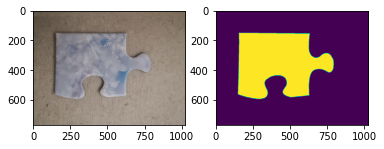

In [7]:

# We load one tile from the dataset and we display it
img = io.imread(DATA_FOLDER.format(0))
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(img)

# We load the ground truth
gt = io.imread(LABEL_FOLDER.format(0))
fig.add_subplot(122)
plt.imshow(gt) 
plt.show()

**UTIL FUNCTIONS**

In [8]:

def random_position(image, tile_shape):
    """ Random 2D patch of shape tile_shape in the image is extracted """
    width, height = tile_shape
    Width, Height = image.shape[-2:]

    x1 = random.randint(0, Width - width - 1)
    x2 = x1 + width
    y1 = random.randint(0, Height - height - 1)
    y2 = y1 + height
    return x1, x2, y1, y2

def Loss_CE(puzzle_input, puzzle_target, weight=None, size_average=True):
    """ Cross entropy loss 2D version """
    dimension = puzzle_input.dim()
    if dimension == 2:
    
        return F.cross_entropy(puzzle_input, puzzle_target, weight, size_average)
        
    elif dimension == 4:
    
        output = puzzle_input.view(puzzle_input.size(0),puzzle_input.size(1), -1)
        output = torch.transpose(output,1,2).contiguous()
        output = output.view(-1,output.size(2))
        puzzle_target = puzzle_target.view(-1)
        return F.cross_entropy(output, puzzle_target,weight, size_average)
        
    else:
        raise ValueError('Needed 2 or 4 dimensions (got {})'.format(dimension))

def accuracy(puzzle_input, puzzle_target):
    """Accuracy function, finds accuracy between prediction and ground truth"""
    return 100 * float(np.count_nonzero(puzzle_input == puzzle_target)) / puzzle_target.size


def sliding_tile(tile, step=10, tile_size=(20,20)):
    """ A tile_shape is slided across the image with a stride of the provided step """
    for x in range(0, tile.shape[0], step):
    
        if x + tile_size[0] > tile.shape[0]:
            x = tile.shape[0] - tile_size[0]
            
        for y in range(0, tile.shape[1], step):
        
            if y + tile_size[1] > tile.shape[1]:
                y = tile.shape[1] - tile_size[1]
                
            yield x, y, tile_size[0], tile_size[1]
            
def sliding_tile_count(tile, step=10, tile_size=(20,20)):
    """ Counts the number of tiles present in an image """
    count = 0
    for x in range(0, tile.shape[0], step):
    
        if x + tile_size[0] > tile.shape[0]:
            x = tile.shape[0] - tile_size[0]
            
        for y in range(0, tile.shape[1], step):
        
            if y + tile_size[1] > tile.shape[1]:
            
                y = tile.shape[1] - tile_size[1]
            count += 1
    return count

def element_group_creator(n, iterable):
    """ Goes through an iterator by chunk of n elements """
    it = iter(iterable)
    while True:
        element_chunk = tuple(itertools.islice(it, n))
        if not element_chunk:
            return
        yield element_chunk

**METRIC FUNCTIONS**

In [9]:
def metrics(pred, gts, label_values=LABELS, print_out=False):
    """Confusin matrix"""
    cm = confusion_matrix(gts,pred,range(len(label_values)))
    if print_out:
      print("Confusion matrix :")
      print(cm)
      
      print("---")
    
    #Calculate global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)
    if print_out:
      print("{} pixels processed".format(total))
      print("Total accuracy : {}%".format(accuracy))
      
      print("---")
    
    # Compute F1 score
    F1Score = np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
        except:
            # Ignore exception if there is no element in class i for test set
            pass
    if print_out:
      print("F1Score :")

      for l_id, score in enumerate(F1Score):
          print("{}: {}".format(label_values[l_id], score))

      print("---")
          
    #Calculate Cohen kappa coefficient
    total = np.sum(cm)
    pa = np.trace(cm) / float(total)
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total*total)
    kappa = (pa - pe) / (1 - pe);

    if print_out:
      print("Kappa: " + str(kappa))
    return accuracy

**DATASET CLASS**

In [10]:
class puzzle_dataset(torch.utils.data.Dataset):
    def __init__(self, ids, data_files=DATA_FOLDER, label_files=LABEL_FOLDER, cache=False, augment=True):
        super(puzzle_dataset, self).__init__()
        
        self.augment = augment
        self.cache = cache
        
        # List of files
        self.data_files = [DATA_FOLDER.format(id) for id in ids]
        self.label_files = [LABEL_FOLDER.format(id) for id in ids]

        # raise an error if files do not exist
        for a in self.data_files + self.label_files:
            if not os.path.isfile(a):
                raise KeyError('{} is not a file !'.format(a))
        
        #Create & Initialize cache dicts
        self.data_cache_ = {}
        self.label_cache_ = {}

    def __len__(self):
        #Epoch size is 10 000 samples
        return 10000
    
    @classmethod
    def augment_data(cls, *arrays, flip=True, mirror=True):

        will_flip, will_mirror = False, False

        if flip and random.random() < 0.5:
            will_flip = True
        if mirror and random.random() < 0.5:
            will_mirror = True
        
        results = []
        for array in arrays:
            if will_flip:
                if len(array.shape) == 2:
                    array = array[::-1, :]
                else:
                    array = array[:, ::-1, :]
            if will_mirror:
                if len(array.shape) == 2:
                    array = array[:, ::-1]
                else:
                    array = array[:, :, ::-1]
            results.append(np.copy(array))
            
        return tuple(results)

    def __getitem__(self, i):
        #Choose a random image
        index = random.randint(0, len(self.data_files) - 1)
        
        #If the tile hasn't been loaded yet, put in cache
        if index in self.data_cache_.keys():
            data = self.data_cache_[index]
        else:
            # Data is normalized in [0, 1]
            data = 1/255 * np.asarray(io.imread(self.data_files[index]).transpose((2,0,1)), dtype='float32')
            if self.cache:
                self.data_cache_[index] = data
            
        if index in self.label_cache_.keys():
            label = self.label_cache_[index]
        else: 
            # Labels are converted from RGB to their numeric values
            label = np.int64( 1/255 * np.asarray((io.imread(self.label_files[index])), dtype='int64'))
            if self.cache:
                self.label_cache_[index] = label
                

        #Random patch selection
        x1, x2, y1, y2 = random_position(data, WINDOW_SIZE)
        data_p = data[:, x1:x2,y1:y2]
        label_p = label[x1:x2,y1:y2]
        
        # Data augmentation if desired
        if self.augment==True:
          data_p, label_p = self.augment_data(data_p, label_p)

        # Return the torch.Tensor values
        return (torch.from_numpy(data_p), torch.from_numpy(label_p) )


**UNET MODEL**

In [11]:
from torchvision import models
"""Weight initialization function""" 
def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            """ According to HE policy for convolution layers """
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()


In [12]:

""" Decoder block function for expansive path in UNet"""
class _DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(_DecoderBlock, self).__init__()
        self.decode = nn.Sequential(
            nn.Conv2d(in_channels, middle_channels, kernel_size=3),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, middle_channels, kernel_size=3),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.decode(x)


In [13]:
class UNet(nn.Module):
    def __init__(self, num_classes,pretrained=True):
        super(UNet, self).__init__()
        vgg = models.vgg16_bn()

        """Use pretrained VGG16 weights"""
        if pretrained:
            vgg.load_state_dict(torch.load("/content/drive/My Drive/vgg16_bn-6c64b313.pth"))

        features = list(vgg.features.children())
        """Contractive path of UNet"""
        self.enc1 = nn.Sequential(*features[0:7])
        self.enc2 = nn.Sequential(*features[7:14])
        self.enc3 = nn.Sequential(*features[14:24])
        self.enc4 = nn.Sequential(*features[24:34])
        """Expansive path of UNet"""
        self.center = _DecoderBlock(512, 1024, 512)
        self.dec4 = _DecoderBlock(1024, 512, 256)
        self.dec3 = _DecoderBlock(512, 256, 128)
        self.dec2 = _DecoderBlock(256, 128, 64)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

        """Weight initialization only for decoder blocks"""
        initialize_weights(self.center, self.dec4, self.dec3, self.dec2, self.dec1, self.final)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        
        """Upsampling and concatenation through skip connections"""
        center = self.center(enc4)
        dec4 = self.dec4(torch.cat([center, F.interpolate(enc4, center.size()[2:], mode='bilinear')], 1))
        dec3 = self.dec3(torch.cat([dec4, F.interpolate(enc3, dec4.size()[2:], mode='bilinear')], 1))
        dec2 = self.dec2(torch.cat([dec3, F.interpolate(enc2, dec3.size()[2:], mode='bilinear')], 1))
        dec1 = self.dec1(torch.cat([dec2, F.interpolate(enc1, dec2.size()[2:], mode='bilinear')], 1))
        final = self.final(dec1)
        return F.interpolate(final, x.size()[2:], mode='bilinear')


**Instantiate the model**

In [14]:
net = UNet(num_classes=N_CLASSES)

**Load model onto GPU**

In [15]:
net.cuda()

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  

**CREATE TRAINING DATASET**

In [16]:
print("Pieces for training : ", X_train)
print("Pieces for validation : ", X_valid)
print("Pieces for testing : ", X_test)

train_set = puzzle_dataset(X_train, cache=CACHE, augment=AUGMENT)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE)

Pieces for training :  ['39', '20', '24', '7', '22', '17', '23', '35', '38', '8', '0', '37', '36', '13', '19', '4', '1', '6', '28', '10', '41', '40', '3', '46', '18', '29', '25', '9', '27', '15', '47', '21', '34', '43']
Pieces for validation :  ['45', '44', '30', '26', '16', '5', '2']
Pieces for testing :  ['31', '11', '33', '14', '42', '12', '32']


**Set Weight training rates and initialize Optimizer**

In [17]:
params_dict = dict(net.named_parameters())
params = []

for key, value in params_dict.items():
    if '_D' in key:
        # Decoder weights are trained at the nominal learning rate
        params += [{'params':[value],'lr': base_lr}]
    else:
        # Encoder weights are trained at lr / 2 (we have VGG-16 weights as initialization)
        params += [{'params':[value],'lr': base_lr / 2}]

optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0005)

**TESTING FUNCTION**

In [18]:
def test(net, test_ids, all=False, stride=WINDOW_SIZE[0], batch_size=BATCH_SIZE, tile_size=WINDOW_SIZE, print_out=False):
    # Use the network on the test set
    test_images = (1 / 255 * np.asarray(io.imread(DATA_FOLDER.format(id)), dtype='float32') for id in test_ids)
    test_labels = ( np.uint8( 1/255 * np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='uint8')) for id in test_ids)

    all_preds = []
    all_gts = []
    val_loss = np.zeros(len(test_ids))
    iter_ = 0
    
    # Switch the network to inference mode
    net.eval()
    
    #Perform testing on images in patches and reconstruct them to give the output mask
    for img, gt in zip(test_images, test_labels):
        pred = np.zeros(img.shape[:2] + (N_CLASSES,))

        total = sliding_tile_count(img, step=stride, tile_size=tile_size) // batch_size
        for i, coords in enumerate(element_group_creator(batch_size, sliding_tile(img, step=stride, tile_size=tile_size))):
            # Display in progress results
            if i > 0 and total > 10 and i % int(10 * total / 100) == 0:
                    _pred = np.argmax(pred, axis=-1)
                    
            # Build the tensor
            with torch.no_grad():
              image_patches = [np.copy(img[x:x+w, y:y+h]).transpose((2,0,1)) for x,y,w,h in coords]
              image_patches = np.asarray(image_patches)
              image_patches = Variable(torch.from_numpy(image_patches).cuda())
            
            # Do the inference
            outs = net(image_patches)
            outs = outs.data.cpu().numpy()
            
            # Fill in the results array
            for out, (x, y, w, h) in zip(outs, coords):
                out = out.transpose((1,2,0))
                pred[x:x+w, y:y+h] += out
            del(outs)

        
        pred_t = Variable(torch.from_numpy(pred).cuda())
        pred_t = pred_t.view(-1,pred_t.size(2))

        pred = np.argmax(pred, axis=-1)
        #Compute loss for when in validation mode
        if all==False:
            gt_t = Variable(torch.from_numpy(gt).type(torch.LongTensor).cuda())
            gt_t = gt_t.view(-1)
            valid_loss = F.cross_entropy(pred_t, gt_t, size_average=True)
            loss = valid_loss.data.item()
            val_loss[iter_]=loss
        iter_+=1

        all_preds.append(pred)
        all_gts.append(gt)

        #Calculate some metrics
        print("----------------------------------------------Single image accuracy------------------------------------------")
        metrics(pred.ravel(), gt.ravel(), print_out=print_out)
        print("----------------------------------------------Global accuracy------------------------------------------------")
        accuracy = metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel(), print_out=print_out)
        
    if all:
        return accuracy, all_preds, all_gts
    else:
        return accuracy, val_loss.mean()

**TRAINING FUNCTION**

In [19]:
def train(net, optimizer, epochs, scheduler=None, weights=WEIGHTS, validate=True):

    #Initialize store arrays
    losses = np.zeros(1000000)
    mean_losses = np.zeros(100000000)
    val_losses = []
    train_losses = []
    weights = weights.cuda()

    criterion = nn.NLLLoss(weight=weights)
    iter_ = 0
    
    for e in range(1, epochs + 1):
        
        #Switch to training mode
        net.train()

        #Train in batches of randomly selected patches, see data.py for more info on patch selection.
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = Variable(data.cuda()), Variable(target.cuda())
            optimizer.zero_grad()
            output = net(data)
            loss = Loss_CE(output, target, weight=weights)
            loss.backward()
            optimizer.step()

            
            #Store loss values
            losses[iter_] = loss.data.item()
            mean_losses[iter_] = np.mean(losses[max(0,iter_-100):iter_])
            
            #Perform validation every 100 iterations
            if iter_ % 100 == 0:
                if iter_>0 and validate:
                    
                    print('TRAIN LOSS')
                    print(loss.data.item())
                    train_losses.append(loss.data.item())

                    print('VALIDATION LOSS')
                    acc1, val_loss = test(net, X_valid, all=False, stride=min(WINDOW_SIZE))
                    print(val_loss)
                    val_losses.append(val_loss)
                    net.train()
                    
                
                rgb = np.asarray(255 * np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='uint8')
                pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
                gt = target.data.cpu().numpy()[0]
                #Print stats every 100 iterations to show progress of training
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                    e, epochs, batch_idx, len(train_loader),
                    100. * batch_idx / len(train_loader), loss.data.item(), accuracy(pred, gt)))
                
            iter_ += 1
            
            del(data, target, loss)
       
    #Print validation and training losses
    
    if validate:
        print(train_losses)
        print(val_losses)
        x = np.linspace(100, 5000, num=49)
        fig = plt.figure()
        fig.add_subplot(111)
        plt.plot(x,train_losses, label='Train Loss')
        plt.plot(x,val_losses, label='Validation Loss')
        plt.title('Train and Validation Loss')
        plt.xlabel('Iterations')  # Add an x-label to the axes.
        plt.ylabel('Loss')  # Add a y-label to the axes.
        plt.legend() 
        #Save graph
        plt.savefig('/content/drive/My Drive/puzzle_corners_1024x768/Graph.png')
    
    #Save model at specified path
    torch.save(net.state_dict(), '/content/drive/My Drive/puzzle_corners_1024x768/cv_final.pth')

**START TRAINING**

In [ ]:
#set epochs to 5, can be altered.
train(net, optimizer, 5)

**LOAD SAVED MODEL**

In [21]:
#Use path where model was saved
net.load_state_dict(torch.load( '/content/drive/My Drive/puzzle_corners_1024x768/cv_final.pth' ))

<All keys matched successfully>

**START TESTING**

In [ ]:
print("--------------------------------------------------TESTING--------------------------------------------------------")
_, all_preds, all_gts = test(net, X_test, all=True, stride=32,print_out=True)

**Save Output**

In [ ]:
"""
for p, id_ in zip(all_preds, X_test):
    plt.imshow(p) and plt.show()
    io.imsave('/content/drive/My Drive/puzzle_corners_1024x768/inference_tile_{}.png'.format(id_), 255*p.astype('uint8'))
"""

**CROSS VALIDATION**

In [ ]:
#6-FOLD CROSS VALIDATION
"""
fold=1
cv = KFold(n_splits=6, random_state=100, shuffle=False)
for train_index, test_index in cv.split(all_ids):
    
    print('Fold: {}'.format(fold))
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)
    
    train(net, optimizer, 5, scheduler, validate=False)
    print("--------------------------------------------------TRAINING--------------------------------------------------------")
    _, all_preds, all_gts = test(net, train_index, all=True, stride=32)
    print("--------------------------------------------------TESTING--------------------------------------------------------")
    _, all_preds, all_gts = test(net, test_index, all=True, stride=32)
    
    print()
    print()
    print()
    fold+=1
"""